In [26]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import torch
import torch.nn as nn
import math
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import os
import nibabel as nib

In [3]:
class VGG(nn.Module):
    def __init__(self, feature_extractor):
        super(VGG, self).__init__()
        self.feature_extractor = feature_extractor

        self.T1_feature_dimension = 64* 64 *3 #1 * 128 * 6 * 6 * 6 # raw T1 data 200*200*200
        
        feature_dimension = self.T1_feature_dimension

        self.classifier = nn.Sequential(
            nn.Dropout(), # commented on 20201230
            nn.Linear(feature_dimension, 1024), #nn.Linear(feature_dimension, 2048),
            nn.ReLU(True),

            nn.Dropout(),
            nn.Linear(1024, 128), #nn.Linear(2048, 512),
            nn.Sigmoid(),
            nn.Linear(128, 2), #nn.Linear(512, 2),
        )

         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x1):
        x1 = self.feature_extractor(x1)
        x = x1.view(x1.size(0), -1)

        x = self.classifier(x)
        return x

# 5-27-2021
class SE_block(nn.Module):
    se_ratio = 16
    def __init__(self,ch,ratio=se_ratio):
        super(SE_block, self).__init__()

        # Both should use the same complex number for initiaization which is then split into real and imaginary parts
        # Weight initialiation using the real part 
        self.globalpooling = nn.AdaptiveAvgPool3d(1)
        # Weight initialization using the imag part
        self.linear1 = nn.Linear(ch,ch//ratio)
        self.relu1 = nn.ReLU()
        self.lienar2 = nn.Linear(ch//ratio,ch)
        self.sigmoid1 = nn.Sigmoid()
        self.ch = ch

    def forward(self, x):
        x_init=x
        x1=self.globalpooling(x).squeeze()
        x1=self.linear1(x1)
        x1=self.relu1(x1)
        x1=self.lienar2(x1)
        x1=self.sigmoid1(x1).reshape(x.shape[0],self.ch,1,1,1)

        return torch.mul(x_init,x1)



In [5]:
def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E']))

def vgg16_bn():
    """VGG 16-layer model (configuration 'D') with batch normalization"""
    return VGG(make_layers(cfg['D']))

def vgg11_bn():
    """VGG 11-layer model (configuration 'A') with batch normalization"""
    return VGG(make_layers(cfg['A']))

def vgg6_bn():
    """VGG 8-layer model (configuration 'F') with batch normalization"""
    return VGG(make_layers(cfg['F']))

In [7]:
def make_layers(cfg, batch_norm=True, se_block=True):
    layers = []
    DropoutRate = 0.10

    in_channels = 1

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool3d(kernel_size=2, stride=2)] # MaxPool without Dropout # commented on 20201230
            #layers += [nn.Dropout(p=DropoutRate), nn.MaxPool3d(kernel_size=2, stride=2)] # MaxPool with Dropout rate of 0.25 # commented on 20201230
        else:
            if batch_norm:
                if se_block:
                    conv3d = nn.Conv3d(in_channels, v, kernel_size=3, padding=1)
                    se3d = SE_block(ch=v)
                    layers += [conv3d, nn.BatchNorm3d(v), se3d, nn.ReLU(inplace=True)]
                else:
                    conv3d = nn.Conv3d(in_channels, v, kernel_size=3, padding=1)
                    layers += [conv3d, nn.BatchNorm3d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv3d, nn.ReLU(inplace=True)]
            in_channels = v
    feature_extractor_T1 = nn.Sequential(*layers)

    return feature_extractor_T1 

cfg = {
    'A': [16, 'M', 32, 'M', 64, 64, 'M', 128, 128, 'M', 128, 128], #'A': [32, 'M', 64, 'M', 64, 64, 'M', 128, 128, 'M', 256, 256, 'M'], 
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [16, 16, 'M', 32, 32, 'M', 64, 64, 64, 64, 'M', 128, 128, 128, 128, 'M', 
          128, 128, 128, 128, 'M'],
    'F': [32, 'M', 128, 'M', 512, 'M'],
}

In [10]:
model = vgg11_bn()

In [38]:
model.feature_extractor[-1]

ReLU(inplace=True)

In [17]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transforms = None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.cn_dir = os.path.join(self.root_dir, "MNI152_affine_WB_iso1mm/CN")
        self.scz_dir = os.path.join(self.root_dir, "MNI152_affine_WB_iso1mm/schiz")
        self.samples, self.labels = self._load_samples()

    def _load_samples(self):
        samples = []
        
        samples = [file for file in os.listdir(self.cn_dir) if file.endswith(".nii.gz")]
        labels = [0] * len(samples)
        samples += [file for file in os.listdir(self.scz_dir) if file.endswith(".nii.gz")]
        labels += [1] * (len(samples) - len(labels))

        return samples, labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label = self.labels[idx]
        if label == 0:
            file_path = os.path.join(self.cn_dir, self.samples[idx])
        else:
            file_path = os.path.join(self.scz_dir, self.samples[idx])
        one_hot_label = torch.zeros(2)
        one_hot_label[label] = 1
        label = one_hot_label

        # Load the NIfTI image
        img = nib.load(file_path)

        # Get the image data array
        img_data = np.float32(img.get_fdata())[0:192, :, 0:192]
        if self.transforms:
            img_tensor = self.transforms(img_data)
        else:
            img_tensor = torch.from_numpy(img_data).unsqueeze(0)
        return img_tensor, label

In [22]:
def downsize_transform(data): 
    target_size = (64, 96, 64)
    data = torch.from_numpy(data).unsqueeze(0).unsqueeze(0)
    downsampled = torch.nn.functional.interpolate(data, size=target_size, mode='trilinear')

    return downsampled.squeeze(0)

In [21]:
root_dir = "/media/youzhi/SSD/bme_project/data"
folds_dir = [dir for dir in os.listdir(root_dir) if dir.startswith("fold")]
folds_dir = [os.path.join(root_dir, dir) for dir in folds_dir]
folds_dir = natsorted(folds_dir)

In [23]:
dataloaders = []
for i in range(len(folds_dir)):
    fold_dir = folds_dir[i]
    dataset = CustomDataset(fold_dir, downsize_transform) #, downsize_transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
    dataloaders.append(dataloader)
    print("fold", i+1, ": ", len(dataset))

fold 1 :  196
fold 2 :  188
fold 3 :  187
fold 4 :  185
fold 5 :  187
fold 6 :  185
fold 7 :  187
fold 8 :  182
fold 9 :  188
fold 10 :  187


torch.Size([8, 1, 64, 96, 64])
<built-in method type of Tensor object at 0x701734f09900>
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
torch.Size([8, 2])


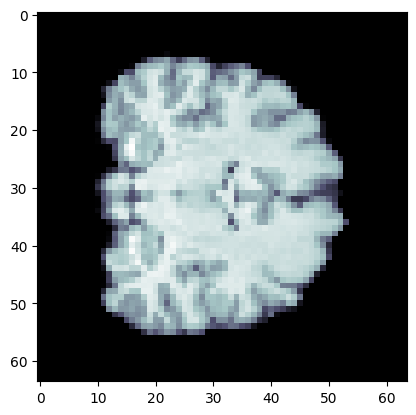

In [27]:
sample = next(iter(dataloaders[0]))
plt.imshow(sample[0][0][0][0:64, int(96/2), 0:64], cmap = 'bone')
print(sample[0].shape)
print(sample[0].type)
print(sample[1])
print(sample[1].shape)

In [39]:
model = vgg11_bn()
target_layers = [model.feature_extractor[-1]]
input_tensor = sample[0]# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

(96, 64, 4)


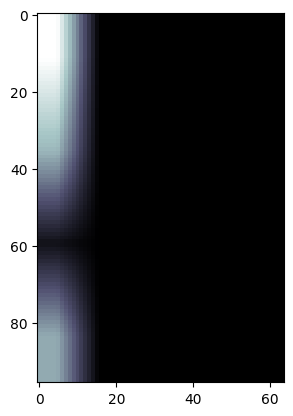

In [41]:
print(grayscale_cam.shape)
plt.imshow(grayscale_cam[0:96, 0:64, 2], cmap='bone')